# Customer Churn Data from SyriaTel

Dataset can be found here[!https://www.kaggle.com/becksddf/churn-in-telecoms-dataset]. 

Predict whether a customer stays or leaves the company. Binary classification.

Business problem: why is predicting churn important? why do I need a model for this? discuss any potential remedies for churn (what do I do with the output of the model) 

Talk about the columns (add in a description for columns)

Results from modelling: brief intro about what sort of results to expect and <b>define precision, recall and accuracy in context of your business problem</b>

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)

[405, 557, 367, 524, 756]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('churn_data.csv')

##  Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Looking at the information above, no missing values. But there are some weird datatypes.

1. state is an object. If I potentially have 50 states, I might need to deal with that a little differently as I don't want 50 categories

2. phone number?

3. international plan?

4. voice mail plan?


In [4]:
df.state.nunique()

51

In [5]:
df['international plan'].value_counts(normalize= True)

no     0.90309
yes    0.09691
Name: international plan, dtype: float64

In [6]:
df['voice mail plan'].value_counts(normalize= True)

no     0.723372
yes    0.276628
Name: voice mail plan, dtype: float64

In [7]:
df['phone number'].value_counts(normalize= True)

415-4609    0.0003
345-2863    0.0003
328-8179    0.0003
376-7207    0.0003
349-4979    0.0003
             ...  
415-2285    0.0003
416-7866    0.0003
360-1406    0.0003
388-9464    0.0003
344-6258    0.0003
Name: phone number, Length: 3333, dtype: float64

 based on the above value counts:
 
 1. For the variable <b>states</b>, we might need to think of a different strategy. Possibly binning
 2. For international plan and voice mail plan, we can simply map the yes and no values to 1 and 0 and that should be solved.
 3. For phone number, dropping it might be a good solution

### Dealing with State

In [8]:
df.state.unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

In [9]:
df_state_division = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')

In [10]:
df_state_division.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [11]:
df_state_division.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       51 non-null     object
 1   State Code  51 non-null     object
 2   Region      51 non-null     object
 3   Division    51 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [12]:
df = df.merge(df_state_division, left_on = 'state', right_on = 'State Code')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [14]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,State,State Code,Region,Division
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,11.01,10.0,3,2.70,1,False,Kansas,KS,Midwest,West North Central
1,KS,70,408,411-4582,no,no,0,232.1,122,39.46,...,9.05,0.0,0,0.00,3,False,Kansas,KS,Midwest,West North Central
2,KS,92,408,386-4170,yes,no,0,62.6,111,10.64,...,9.98,10.4,2,2.81,1,True,Kansas,KS,Midwest,West North Central
3,KS,137,408,352-8202,no,no,0,205.9,88,35.00,...,13.05,14.5,4,3.92,2,False,Kansas,KS,Midwest,West North Central
4,KS,132,415,369-3214,no,no,0,83.4,110,14.18,...,6.60,7.6,5,2.05,1,False,Kansas,KS,Midwest,West North Central


<AxesSubplot:xlabel='count', ylabel='Division'>

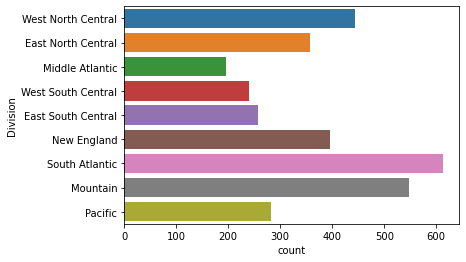

In [15]:
sns.countplot(y= "Division", data = df)

In [16]:
df.drop(columns = ['state', 'State', 'State Code', 'Region'], axis = 1, inplace= True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   phone number            3333 non-null   object 
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [18]:
df.head()

,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,Division
0,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,False,West North Central
1,70,408,411-4582,no,no,0,232.1,122,39.46,292.3,...,24.85,201.2,112,9.05,0.0,0,0.00,3,False,West North Central
2,92,408,386-4170,yes,no,0,62.6,111,10.64,180.6,...,15.35,221.7,80,9.98,10.4,2,2.81,1,True,West North Central
3,137,408,352-8202,no,no,0,205.9,88,35.00,209.3,...,17.79,289.9,84,13.05,14.5,4,3.92,2,False,West North Central
4,132,415,369-3214,no,no,0,83.4,110,14.18,232.2,...,19.74,146.7,114,6.60,7.6,5,2.05,1,False,West North Central


### Changing International plan to int

In [19]:
df['international plan'] = df['international plan'].map(lambda x: 1 if x == 'yes' else 0)

In [20]:
df['international plan'].value_counts()

0    3010
1     323
Name: international plan, dtype: int64

### Changing voice mail plan to int

In [21]:
df['voice mail plan'] = df['voice mail plan'].map(lambda x: 1 if x == 'yes' else 0)

In [22]:
df['voice mail plan'].value_counts()

0    2411
1     922
Name: voice mail plan, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   phone number            3333 non-null   object 
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

### Dropping phone number

In [24]:
df.drop(columns=['phone number'], axis = 1, inplace= True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   international plan      3333 non-null   int64  
 3   voice mail plan         3333 non-null   int64  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

### Dummies for division and final cleaning

In [26]:
division_dummies = pd.get_dummies(df['Division'], prefix = 'division')

In [27]:
division_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   division_East North Central  3333 non-null   uint8
 1   division_East South Central  3333 non-null   uint8
 2   division_Middle Atlantic     3333 non-null   uint8
 3   division_Mountain            3333 non-null   uint8
 4   division_New England         3333 non-null   uint8
 5   division_Pacific             3333 non-null   uint8
 6   division_South Atlantic      3333 non-null   uint8
 7   division_West North Central  3333 non-null   uint8
 8   division_West South Central  3333 non-null   uint8
dtypes: uint8(9)
memory usage: 215.3 KB


In [29]:
df_cleaned = pd.concat([df, division_dummies], axis = 1)

In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   account length               3333 non-null   int64  
 1   area code                    3333 non-null   int64  
 2   international plan           3333 non-null   int64  
 3   voice mail plan              3333 non-null   int64  
 4   number vmail messages        3333 non-null   int64  
 5   total day minutes            3333 non-null   float64
 6   total day calls              3333 non-null   int64  
 7   total day charge             3333 non-null   float64
 8   total eve minutes            3333 non-null   float64
 9   total eve calls              3333 non-null   int64  
 10  total eve charge             3333 non-null   float64
 11  total night minutes          3333 non-null   float64
 12  total night calls            3333 non-null   int64  
 13  total night charge

In [32]:
df_cleaned.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,Division,division_East North Central,division_East South Central,division_Middle Atlantic,division_Mountain,division_New England,division_Pacific,division_South Atlantic,division_West North Central,division_West South Central
0,128,415,0,1,25,265.1,110,45.07,197.4,99,...,West North Central,0,0,0,0,0,0,0,1,0
1,70,408,0,0,0,232.1,122,39.46,292.3,112,...,West North Central,0,0,0,0,0,0,0,1,0
2,92,408,1,0,0,62.6,111,10.64,180.6,126,...,West North Central,0,0,0,0,0,0,0,1,0
3,137,408,0,0,0,205.9,88,35.00,209.3,86,...,West North Central,0,0,0,0,0,0,0,1,0
4,132,415,0,0,0,83.4,110,14.18,232.2,137,...,West North Central,0,0,0,0,0,0,0,1,0


In [33]:
df_cleaned.drop(columns=['Division'], axis = 1, inplace= True)

In [34]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   account length               3333 non-null   int64  
 1   area code                    3333 non-null   int64  
 2   international plan           3333 non-null   int64  
 3   voice mail plan              3333 non-null   int64  
 4   number vmail messages        3333 non-null   int64  
 5   total day minutes            3333 non-null   float64
 6   total day calls              3333 non-null   int64  
 7   total day charge             3333 non-null   float64
 8   total eve minutes            3333 non-null   float64
 9   total eve calls              3333 non-null   int64  
 10  total eve charge             3333 non-null   float64
 11  total night minutes          3333 non-null   float64
 12  total night calls            3333 non-null   int64  
 13  total night charge

In [38]:
df_cleaned.to_csv('cleaned_churn_data.csv')

## EDA

### Checking the class imbalance

<AxesSubplot:xlabel='churn', ylabel='count'>

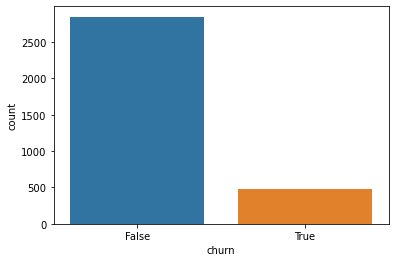

In [46]:
sns.countplot(x = 'churn', data = df_cleaned)

### Plotting international plan vs churn

<AxesSubplot:xlabel='international plan', ylabel='count'>

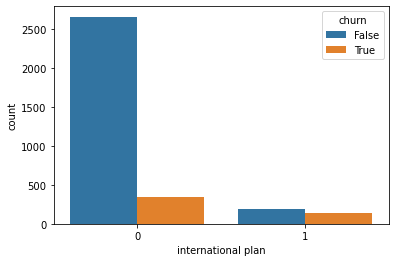

In [39]:
sns.countplot(x = 'international plan', data = df_cleaned, hue = 'churn')

### Plotting customer service calls vs churn

<AxesSubplot:xlabel='customer service calls', ylabel='count'>

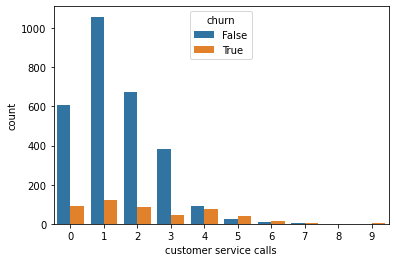

In [40]:
sns.countplot(x = 'customer service calls', data = df_cleaned, hue = 'churn')

We can clearly see that as the <b>number of customer service calls start increasing the percent of customers churning starts to increase as well</b>. Due to the nature of the data, we will need to investigate this separately

<AxesSubplot:xlabel='customer service calls', ylabel='count'>

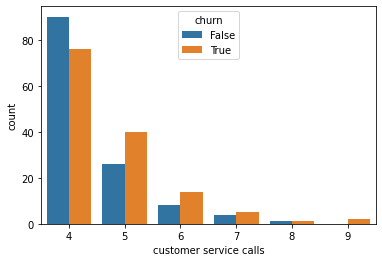

In [47]:
sns.countplot(x = 'customer service calls', 
              data = df_cleaned[df_cleaned['customer service calls'] > 3], 
              hue = 'churn')

### Customer churn by geographic region

We can see that the churn increases significantly beyond 5 calls to customer service. Unfortunately we don't have enough data to get any good insights here

<AxesSubplot:xlabel='count', ylabel='Division'>

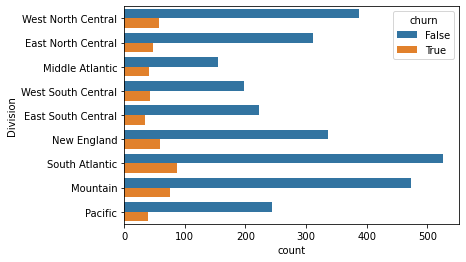

In [54]:
sns.countplot(y = 'Division', data = df, hue = 'churn')

In [61]:
df_division_grouped = df.groupby('Division').agg(['sum', 'count'])

In [64]:
df_division_grouped = df_division_grouped.reset_index()

In [68]:
df_division_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   (Division, )                     9 non-null      object 
 1   (account length, sum)            9 non-null      int64  
 2   (account length, count)          9 non-null      int64  
 3   (area code, sum)                 9 non-null      int64  
 4   (area code, count)               9 non-null      int64  
 5   (international plan, sum)        9 non-null      int64  
 6   (international plan, count)      9 non-null      int64  
 7   (voice mail plan, sum)           9 non-null      int64  
 8   (voice mail plan, count)         9 non-null      int64  
 9   (number vmail messages, sum)     9 non-null      int64  
 10  (number vmail messages, count)   9 non-null      int64  
 11  (total day minutes, sum)         9 non-null      float64
 12  (total day minutes, count)

In [65]:
df_division_grouped.head()

Division account length       area code       international plan  \
                                 sum count       sum count                sum   
0  East North Central          35786   358    156877   358                 44   
1  East South Central          24668   257    111703   257                 26   
2     Middle Atlantic          19854   196     85564   196                 20   
3            Mountain          55795   548    239159   548                 45   
4         New England          39305   395    172335   395                 42   

        voice mail plan       number vmail messages  ... total intl minutes  \
  count             sum count                   sum  ...                sum   
0   358             104   358                  3071  ...             3645.0   
1   257              71   257                  1974  ...             2691.5   
2   196              50   196                  1471  ...             2035.9   
3   548             156   548                  4502  ...             5661.3   
4   395             107   395                  3092  ...             3956.0   

        total intl calls       total intl charge       customer service calls  \
  count              sum count               sum count                    sum   
0   358             1551   358            984.32   358                    522   
1   257             1155   257            726.77   257                    406   
2   196              878   196            549.76   196                    313   
3   548             2526   548           1528.78   548                    867   
4   395             1780   395           1068.27   395                    603   

        churn        
  count   sum count  
0   358    47   358  
1   257    35   257  
2   196    41   196  
3   548    75   548  
4   395    59   395  

[5 rows x 39 columns]

In [ ]:
df_division_grouped.pivot(index = 'Division', )